# Fitting the conductance to Mott law and rare-chain hopping

In this notebook, we evaluate the agreement between the conductivity-temperature relation exhibited by our parametrisation of the toy model and Mott's law and rare-chain hopping.

## **Step 0:** Import packages and load data

In [6]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import rcParams
from os import path
from tensor_linregress import tensor_linregress
from param_parser import ParameterParser
import plt_utils

rcParams['image.aspect'] = 'auto'

kB = 8.617e-5

npydir = 'ohmic_dmu0.05_aligned_focused'
param_file = 'aligned_focused_max_dmu0.02_fine_grids.json'

pp = ParameterParser(param_file)

kappa_grid, w0_grid, temp_grid, e_grid = \
pp.load_grids(plist=['kappa_grid', 'frequency_grid',\
    'temperature_grid', 'energy_grid'])

e_d, e_a, gamL, gamR, gam_phonon = pp.load_intrinsic()

dmu = pp.load_specific(['ohmic_dmu'])[0]

beta_grid = 1.0/(kB*temp_grid)

I = np.load(path.join(npydir,'MAC_current_dis_dmu0.005_aligned.npy'))
print(I.shape)
# Order of indices in I is (w0, kappa, T)

G = I/dmu # conductance (assume ohmic regime I ~ dmu)
logG = np.log(G)

rtol = 0.95 #threshold for what we consider a 'good' fit


(51, 11, 4000)


## **Step 1:** Fit to Mott's law in 1 dimension:

Mott's law describes the temperature dependence of the conductivity of a disordered solid in $d$ dimensions. It states:

$$
G = G_0\,\text{exp}\left\{-\left(\frac{T_0}{T}\right)^{1/(d+1)}\right\} = G_0\,\text{exp}\left\{-\sqrt{\frac{T_0}{T}}\right\}
$$

We therefore have $\ln G \propto \sqrt{\beta}$.

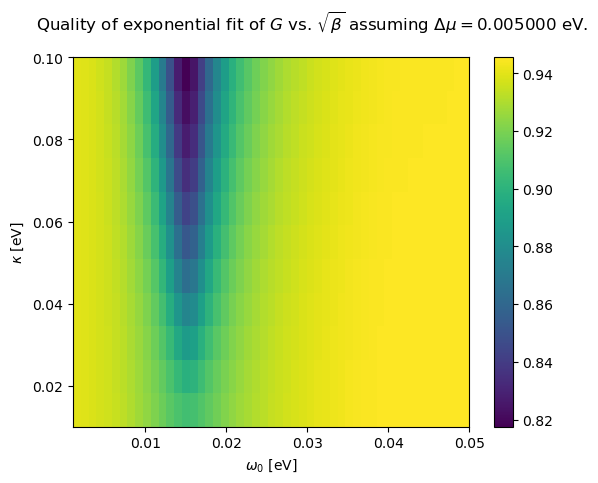

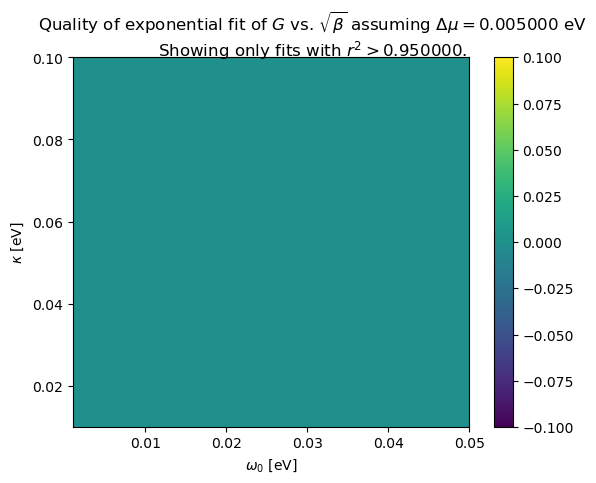

0.048189586512197624


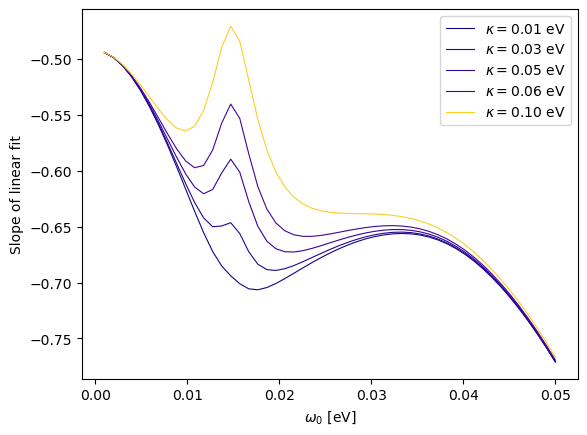

In [7]:
x = np.sqrt(beta_grid)
a_mott, b_mott, r_mott = tensor_linregress(x,logG)

plt.imshow((r_mott**2).T,origin='lower',extent=[*w0_grid[[0,-1]], *kappa_grid[[0,-1]]])
plt.xlabel('$\omega_0$ [eV]')
plt.ylabel('$\kappa$ [eV]')
plt.suptitle('Quality of exponential fit of $G$ vs. $\sqrt{\\beta}$ assuming $\Delta\mu = %f$ eV.'%(dmu))
plt.colorbar()
plt.show()

plt.imshow(((r_mott**2) > rtol).T,origin='lower',extent=[*w0_grid[[0,-1]], *kappa_grid[[0,-1]]])
plt.xlabel('$\omega_0$ [eV]')
plt.ylabel('$\kappa$ [eV]')
plt.suptitle('Quality of exponential fit of $G$ vs. $\sqrt{\\beta}$ assuming $\Delta\mu = %f$ eV\nShowing only fits with $r^2 > %f$.'%(dmu,rtol))
plt.colorbar()
plt.show()

print(np.max(np.abs(r_mott - r_mott[:,0][:,None])))

cm = plt_utils.get_cm(w0_grid,'plasma',max_val=0.9)

inds = [0,2,4,6,-1]

for kappa, a, c in zip(kappa_grid[inds],a_mott.T[inds],cm[inds]):
    plt.plot(w0_grid, a, ls='-',c=c, lw=0.8,label='$\kappa={:5.2f}$ eV'.format(kappa))
plt.xlabel('$\omega_0$ [eV]')
plt.ylabel('Slope of linear fit')
plt.legend()
plt.show()

np.save('fit_params_mott.npy',np.vstack((a_mott[:,0],b_mott[:,0],r_mott[:,0])))

#print(np.max(np.abs(r1 - r1[:,0][:,None])))

## **Step 2:** Fit to rare chain hopping

Rare chain hopping is another model for charge transport in disordered solids (usually imbued with some structure, e.g. polymer thin film). It predicts a power law conductivity-temperature dependence $G\sim T^{\alpha}\implies \ln G \sim \ln T$.

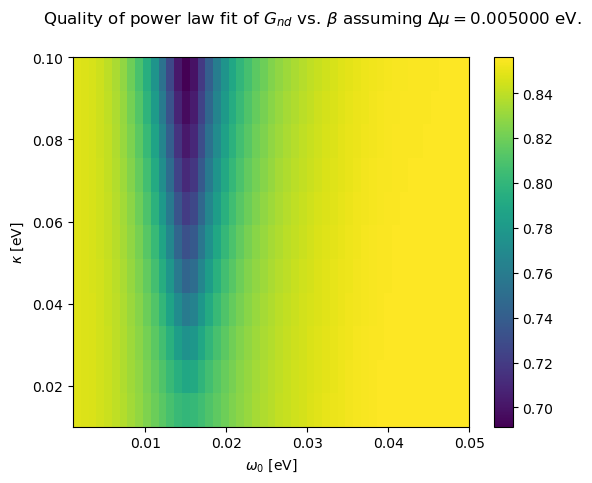

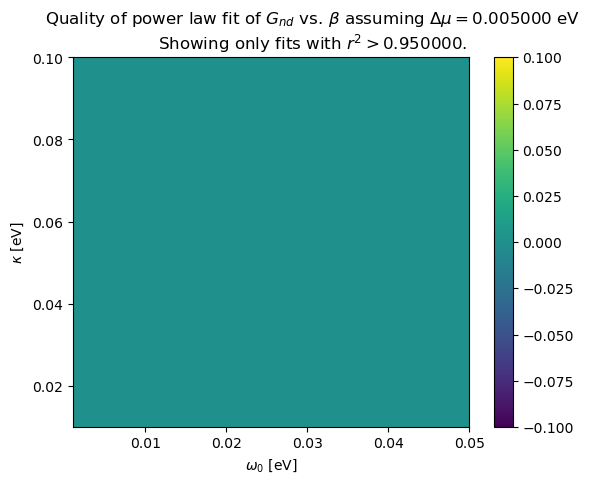

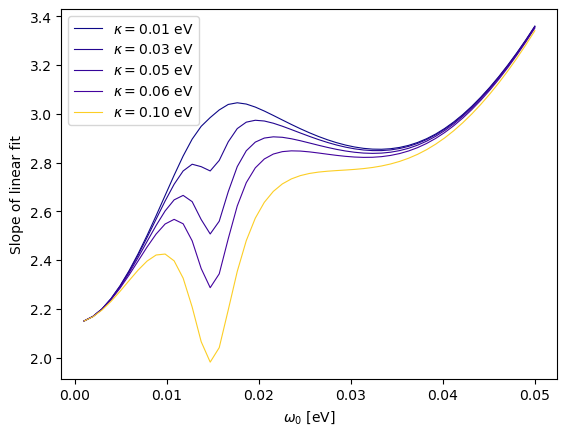

In [8]:
x = np.log(temp_grid)
a_rch, b_rch, r_rch = tensor_linregress(x,logG[:,:,:])

plt.imshow((r_rch**2).T,origin='lower',extent=[*w0_grid[[0,-1]], *kappa_grid[[0,-1]]])
plt.xlabel('$\omega_0$ [eV]')
plt.ylabel('$\kappa$ [eV]')
plt.suptitle('Quality of power law fit of $G_{nd}$ vs. $\\beta$ assuming $\Delta\mu = %f$ eV.'%(dmu))
plt.colorbar()
plt.show()

plt.imshow(((r_rch**2) > rtol).T,origin='lower',extent=[*w0_grid[[0,-1]], *kappa_grid[[0,-1]]])
plt.xlabel('$\omega_0$ [eV]')
plt.ylabel('$\kappa$ [eV]')
plt.suptitle('Quality of power law fit of $G_{nd}$ vs. $\\beta$ assuming $\Delta\mu = %f$ eV\nShowing only fits with $r^2 > %f$.'%(dmu,rtol))
plt.colorbar()
plt.show()

#print(np.max(np.abs(r1 - r1[:,0][:,None])))

np.save('fit_params_rch.npy',np.vstack((a_rch[:,0],b_rch[:,0],r_rch[:,0])))

for kappa, a, c in zip(kappa_grid[inds],a_rch.T[inds],cm[inds]):
    plt.plot(w0_grid, a, ls='-',c=c, lw=0.8,label='$\kappa={:5.2f}$ eV'.format(kappa))
plt.xlabel('$\omega_0$ [eV]')
plt.ylabel('Slope of linear fit')
plt.legend()
plt.show()

Compare global agreements between the toy model's predictions and Mott's law/rare chain hopping.

In [11]:
print('Mott fits our model better than RCH for all (w0,kappa) conditions: ', np.all(r_rch**2 < r_mott**2))

Mott fits our model better than RCH for all (w0,kappa) conditions:  True


OK so it seems that our toy model is in better agreement overall with Mott's law than with rare chain hopping.

Furthermore, so there seems that when $\omega_0\approx 0.015$ eV, the $G(T)$ predicted by our model exhibits very poor agreement with either Mott's law or rare chain hopping. This seems to be amplified at higher values of $\kappa$; let's investigate.

RCH r^2 fit argmins: [14 14 14 14 14 14 14 14 14 14 14]
Mott r^2 fit argmins: [14 14 14 14 14 14 14 14 14 14 14]
RCH slope argmins: [14 14 14 14 14 14 14 14 14 14 14]
Mott slope argmaxs: [14 14 14 14 14 14 14 14 14 14 14]
Interesing value of omega_0 = 0.01472 eV
e_a - e_d = 0.014908914234732507 eV


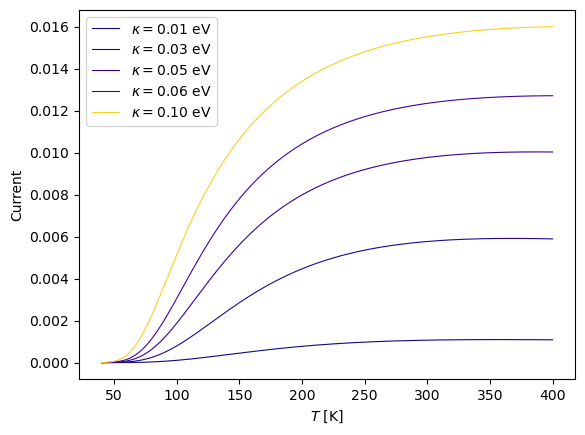

In [10]:
# First check if everything happens at the same value of w0
mind_mott = np.argmin(r_mott**2,axis=0)
mind_rch = np.argmin(r_rch**2,axis=0)

print('RCH r^2 fit argmins:', mind_mott)
print('Mott r^2 fit argmins:', mind_mott)

print('RCH slope argmins:', np.argmin(r_rch,axis=0))
print('Mott slope argmaxs:', np.argmax(r_mott,axis=0))

interesting_ind = mind_mott[0]

print('Interesing value of omega_0 = {} eV'.format(w0_grid[interesting_ind]))
print('e_a - e_d = {} eV'.format(e_a - e_d))

# Plot IvT at for this value of w0
for kappa, ii, c in zip(kappa_grid[inds],I[interesting_ind,inds],cm[inds]):
    plt.plot(temp_grid, ii, ls='-',c=c, lw=0.8,label='$\kappa={:5.2f}$ eV'.format(kappa))
plt.xlabel('$T$ [K]')
plt.ylabel('Current')
plt.legend()
plt.show()

